In [1]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score
import seaborn as sns
from scipy.stats import zscore
import optuna
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from sklearn.preprocessing import StandardScaler

c:\Users\Administrator\Desktop\FinetuningOptuna\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\Administrator\Desktop\FinetuningOptuna\venv\lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


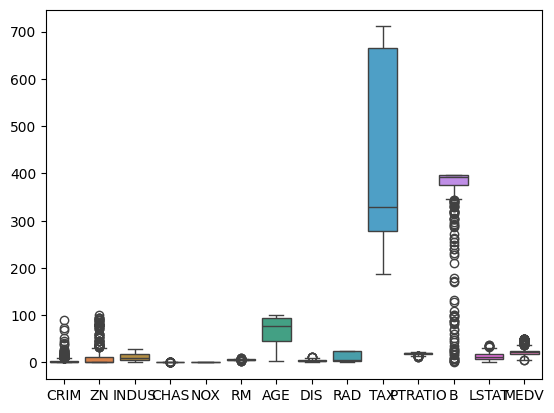

In [2]:
data = pd.read_csv("C:/Users/Administrator/Desktop/FinetuningOptuna/boston.csv")
sns.boxplot(data)
out = IForest(contamination=0.1)
out_pred = out.fit_predict(data)
std_data = data[out_pred == 1]

<Axes: >

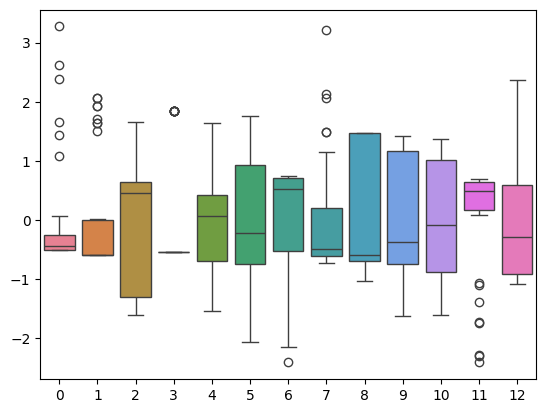

In [3]:
X = std_data.drop("MEDV", axis = 1)
y = std_data["MEDV"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
sns.boxplot(X_train_scaled)


In [4]:
model = MLPRegressor()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
r2_score(y_test, y_pred)

c:\Users\Administrator\Desktop\FinetuningOptuna\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.4727966899365754

In [ ]:
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 5)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_l{i}', 16, 128)) 
    solver = trial.suggest_categorical('solver', ['lbfgs', 'adam'])
    hyperparams = {
        'hidden_layer_sizes': tuple(layers),
        'activation': trial.suggest_categorical('activation', ['tanh', 'relu']),
        'solver': solver,
        'alpha': trial.suggest_float('alpha', 1e-5, 1.0, log=True),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 0.05, log=True),
        'max_iter': 2000,
        'tol': trial.suggest_float('tol', 1e-5, 1e-3, log=True),
        'early_stopping': True,
        'validation_fraction': 0.1,
        'n_iter_no_change': 20
    }
    if solver == 'adam':
        hyperparams['beta_1'] = trial.suggest_float('beta_1', 0.85, 0.99)
        hyperparams['beta_2'] = trial.suggest_float('beta_2', 0.9, 0.9999)
        hyperparams['epsilon'] = trial.suggest_float('epsilon', 1e-9, 1e-6, log=True)
    elif solver == 'sgd': # No lo estoy ocupando pero se puede usar tambien
        hyperparams['learning_rate'] = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
        hyperparams['momentum'] = trial.suggest_float('momentum', 0.1, 0.9)
        hyperparams['nesterovs_momentum'] = trial.suggest_categorical('nesterovs_momentum', [True, False])
    try:
        model = MLPRegressor(**hyperparams, random_state=369)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        r2 = r2_score(y_test, y_pred)
        return r2 if r2 > 0 else -1.0
    except Exception as e:
        print(e)
        return -1.0
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_jobs=-1, n_trials=100)

[I 2025-08-23 22:45:00,699] A new study created in memory with name: no-name-6dde9b8c-8333-48c4-8102-d66baa62f88c
[I 2025-08-23 22:45:01,911] Trial 8 finished with value: -1.0 and parameters: {'n_layers': 4, 'n_units_l0': 235, 'n_units_l1': 149, 'n_units_l2': 124, 'n_units_l3': 36, 'solver': 'adam', 'activation': 'tanh', 'alpha': 1.7935772453447493e-05, 'learning_rate_init': 0.03931063877094243, 'tol': 0.000935584078688076, 'beta_1': 0.85077177074964, 'beta_2': 0.9530618704690922, 'epsilon': 4.205534666598458e-09}. Best is trial 8 with value: -1.0.
[I 2025-08-23 22:45:02,563] Trial 7 finished with value: -1.0 and parameters: {'n_layers': 2, 'n_units_l0': 119, 'n_units_l1': 192, 'solver': 'adam', 'activation': 'tanh', 'alpha': 2.0804718871756403e-05, 'learning_rate_init': 0.005535706887337371, 'tol': 0.0008493528421622961, 'beta_1': 0.9357041106945094, 'beta_2': 0.9797035075951424, 'epsilon': 9.482996213549384e-08}. Best is trial 8 with value: -1.0.
[I 2025-08-23 22:45:03,301] Trial 0 f